## SLU17 - Ethics & Fairness - Exercise notebook

In [1]:
import warnings
warnings.filterwarnings('ignore')
import hashlib

import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')
%matplotlib inline

import pandas as pd
from sklearn.metrics import confusion_matrix
import numpy as np

from utils.utils import make_data

# Criminal justice bias

Exercise adaptated from the book [Fairness and Machine Learning by Solon Barocas, Moritz Hardt, and Arvind Narayanan](https://fairmlbook.org/pdf/fairmlbook.pdf).

Based on the ProPublica's article [Machine Bias](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) about a proprietary risk score, called COMPAS, used in the US.

This is the problem setting:

> Risk assessment is an important component of the criminal justice system. In the United States, judges set bail and decide pre-trial detention based on their assessment of the risk that a released defendant would fail to appear at trial or cause harm to the public.

These scores are intended to assess the risk that a defendant will re-offend, a task often called **recidivism prediction**.

We’ll use data obtained and released by ProPublica.

In [2]:
data = make_data()

In [3]:
data.head()

,sex,age,age_cat,race,decile_score,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_charge_degree,is_recid,score_text,two_year_recid
0,Male,69,Greater than 45,Other,1,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,F,0,Low,0
1,Male,34,25 - 45,African-American,3,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,F,1,Low,1
2,Male,24,Less than 25,African-American,4,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,F,1,Low,1
5,Male,44,25 - 45,Other,1,0,0.0,2013-11-30 04:50:18,2013-12-01 12:28:56,M,0,Low,0
6,Male,41,25 - 45,Caucasian,6,14,-1.0,2014-02-18 05:08:24,2014-02-24 12:18:30,F,1,Medium,1


## Exercise 1 - Score distribution

### Score distribution

Plot the histogram of the scores, `decile_score`.

Suggestion: Use `Series.hist(histtype='step')`.

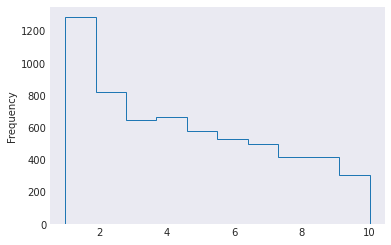

In [4]:
data.decile_score.plot.hist(histtype='step')
plt.show()

### Score distribution by race

Plot the histogram of the scores for black (`race == "African-American"`) and white defendants (`race == "Caucasian"`).

#### White Defendants’ Risk Scores

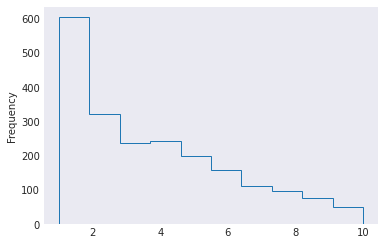

In [5]:
data.where(data.race == "Caucasian").decile_score.plot.hist(histtype='step')
plt.show()

#### Black Defendants’ Risk Scores

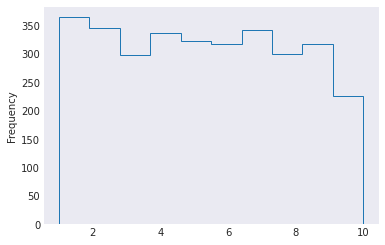

In [6]:
data.where(data.race == "African-American").decile_score.plot.hist(histtype='step')
plt.show()

### Interpretation

Based on these plots, what would you conclude from the distributions. Uncomment the correct answer.

In [7]:
# hypothesis_1 = 'The distribution of the scores are similar for both populations.'
hypothesis_1 = 'Scores for white defendants are skewed toward lower-risk categories.'
# hypothesis_1 = 'Scores for black defendants are skewed toward lower-risk categories.'

In [8]:
expected_hash_1 = '1d0a31bdfb0e6cd81f854bad389789d7fd0022bdf92534fc6fbd0c80bc40e817'
assert hashlib.sha256(str(hypothesis_1).encode('utf-8')).hexdigest() == expected_hash_1

## Exercise 2 - Error rates

### Overall

Plot the histogram of scores received by the positive class (recidivists). Use the column `two_year_recid`.

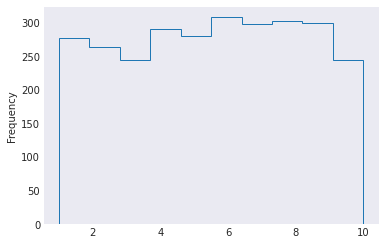

In [9]:
data.where(data.two_year_recid == 1).decile_score.plot.hist(histtype='step')
plt.show()

Overall, the risk score doesn't appear to be particularly good at separating recidivists.

(The resulting histogram should resemble a uniform distribution.)

### By race

Plot the same histogram for black (`race == "African-American"`) and white defendants (`race == "Caucasian"`).

#### White Defendants

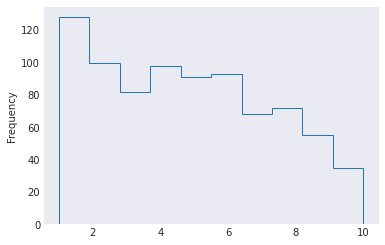

In [10]:
data.where((data.two_year_recid == 1) & (data.race == "Caucasian")).decile_score.plot.hist(histtype='step')
plt.show()

#### Black Defendants

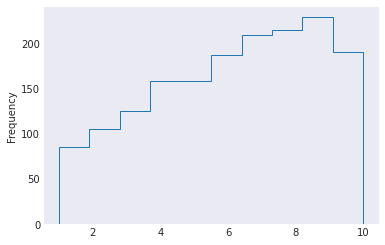

In [11]:
data.where((data.two_year_recid == 1) & (data.race == "African-American")).decile_score.plot.hist(histtype='step')
plt.show()

## Interpretation

Based on these results, uncomment the correct answer.

(Remember, these histograms report to **actual recidivists**.)  

In [12]:
# hypothesis_2 = 'The distribution of recidivists scores is similar in both groups.'
hypothesis_2 = 'Scores for white recidivists are skewed toward lower-risk categories.'
# hypothesis_2 = 'Scores for black recidivists are skewed toward lower-risk categories.'

In [13]:
expected_hash_2 = '8fb14ceb9ee8aefb715152afa576bb0f7af71bb7671062a8d94c1b813897b936'
assert hashlib.sha256(str(hypothesis_2).encode('utf-8')).hexdigest() == expected_hash_2

## Exercise 3 - When predictions fail differently

Defendants with `decile_score` higher than 3 are classified as high-risk of recidivism.

We use `scikit-learn` to compute the confusion matrix by race for us.

### False Positive Rate (FPR)

The false positive rate, also known as probability of false alarm, is given by:

$$FPR = \frac{FP}{FP + TN} = \frac{FP}{N}$$

Where $FP$ is the number of false positives, $TN$ is the number of true negatives, and $N$ the total number of negatives.

Below, we compute the global FPR of the `decile_score`.

In [14]:
y_true = data['two_year_recid']
y_pred = data['decile_score'] > 3

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

fpr = fp / (fp + tn)

In [15]:
fpr

0.4142134998513232

#### White Defendants

Compute the FPR for white defendants.

In [16]:
y_true_w = y_true[data.race == "Caucasian"]
y_pred_w = y_pred[data.race == "Caucasian"]

tn_w, fp_w, fn_w, tp_w = confusion_matrix(y_true_w, y_pred_w).ravel()

In [17]:
fpr_w = fp_w / (fp_w + tn_w)
fpr_w

0.3333333333333333

In [18]:
assert np.isclose(fpr_w, 0.33, atol=0.01)

#### Black Defendants

Compute the FPR for black defendants.

In [19]:
y_true_b = y_true[data.race == "African-American"]
y_pred_b = y_pred[data.race == "African-American"]

tn_b, fp_b, fn_b, tp_b = confusion_matrix(y_true_b, y_pred_b).ravel()

In [20]:
fpr_b = fp_b / (fp_b + tn_b)
fpr_b

0.5416116248348745

In [21]:
assert np.isclose(fpr_b, 0.54, atol=0.01)